## Universidad Nacional de Chimborazo

**Facultad:** Facultad de Ingeniería  
**Carrera:** Ciencia de Datos e IA  
**Materia:** Modelamiento  
**Docente:** Estalin Mejia H.  
**Semestre:** Tercero

---

### Trabajo Autónomo 2

### Análisis de Regresión Lineal Múltiple: Predicción de Tarifas de Taxis en Nueva York

**Autores:**  
- Alisson Atupaña
- Mario Camacho
- Lenin Lopez

**Fecha:** 26 de octubre de 2025

**Riobamba - Ecuador**

---


#
<div style="display:flex; align-items:flex-start; gap:14px; background:linear-gradient(90deg,#1e3a8a,#3b82f6); padding:20px; border-radius:12px; box-shadow:0 8px 20px rgba(30,58,138,0.25); color:#fff; max-width:fit-content; width:min(900px,100%); margin:16px auto; box-sizing:border-box;">
    <div style="width:40px; height:40px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.1); border-radius:8px; font-size:1.8rem; line-height:1;">📋</div>
    <div>
        <div style="font-weight:900; font-size:1.8rem; letter-spacing:0.5px;">Introducción y Contexto</div>
        <div style="opacity:0.9; font-size:0.95rem; margin-top:6px;">Exploración inicial del conjunto de datos de tarifas de taxis en Nueva York, incluyendo carga de librerías, importación de datos y análisis estructural para preparar el análisis de regresión lineal múltiple.</div>
    </div>
</div>

##
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#ea580c,#f97316); padding:16px; border-radius:10px; box-shadow:0 6px 15px rgba(234,88,12,0.2); color:#fff; max-width:fit-content; width:min(850px,100%); margin:12px auto; margin-left:40px; box-sizing:border-box;">
    <div style="width:32px; height:32px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.45rem; line-height:1;">🔍</div>
    <div>
        <div style="font-weight:800; font-size:1.35rem; letter-spacing:0.3px;">Instalacion y carga de librerías</div>
    </div>
</div>

###
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#ca8a04,#eab308); padding:12px; border-radius:8px; box-shadow:0 4px 12px rgba(202,138,4,0.15); color:#fff; max-width:fit-content; width:min(750px,100%); margin:8px auto; margin-left:120px; box-sizing:border-box;">
    <div style="width:24px; height:24px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:4px; font-size:1rem; line-height:1;">⚠️</div>
    <div>
        <div style="font-weight:600; font-size:1rem;">Advertencia:</div>
        <div style="opacity:0.85; font-size:0.8rem; margin-top:2px;">Las liberias solo se deben instalar la primera vez.</div>
    </div>
</div>

In [1]:
install.packages(c("readr", "dplyr", "ggplot2", "car", "GGally", "gridExtra", "psych", "PerformanceAnalytics", "lubridate"), verbose = FALSE, quiet = TRUE)

package 'readr' successfully unpacked and MD5 sums checked
package 'dplyr' successfully unpacked and MD5 sums checked
package 'ggplot2' successfully unpacked and MD5 sums checked
package 'car' successfully unpacked and MD5 sums checked
package 'GGally' successfully unpacked and MD5 sums checked
package 'gridExtra' successfully unpacked and MD5 sums checked
package 'psych' successfully unpacked and MD5 sums checked
package 'PerformanceAnalytics' successfully unpacked and MD5 sums checked
package 'lubridate' successfully unpacked and MD5 sums checked


In [2]:
library(readr) # para leer los datos
library(dplyr) # para manipulación de datos
library(ggplot2) # para visualización de los datos
library(car) # para análisis de regresión lineal
library(GGally) # para gráficos correlacionales
library(gridExtra) # para organizar múltiples gráficos
library(PerformanceAnalytics) # para análisis de correlación avanzada
library(lubridate) # para manipulación de fechas y horas


Adjuntando el paquete: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Cargando paquete requerido: carData


Adjuntando el paquete: 'car'


The following object is masked from 'package:dplyr':

    recode



Adjuntando el paquete: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Cargando paquete requerido: xts

Cargando paquete requerido: zoo


Adjuntando el paquete: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctl

##
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#ea580c,#f97316); padding:16px; border-radius:10px; box-shadow:0 6px 15px rgba(234,88,12,0.2); color:#fff; max-width:fit-content; width:min(850px,100%); margin:12px auto; margin-left:40px; box-sizing:border-box;">
    <div style="width:32px; height:32px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.45rem; line-height:1;">🔍</div>
    <div>
        <div style="font-weight:800; font-size:1.35rem; letter-spacing:0.3px;">Carga de los datos y estructura del dataset</div>
    </div>
</div>

In [3]:
datos <- readRDS("datos.rds") 

In [4]:
head(datos) # muestra las primeras filas del dataset

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RatecodeID
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2016-03-27 21:14:57,2016-03-27 21:20:27,1,1.12,-73.98667,40.72813,NA,N,-73.98641,40.73848,1,6.0,0.5,0.5,1.46,0,0.3,8.76,1
2,2016-02-20 18:15:45,2016-02-20 18:46:13,1,3.80,-73.98663,40.77701,NA,N,-74.00238,40.73035,1,19.5,0.0,0.5,1.50,0,0.3,21.80,1
2,2016-01-02 17:26:54,2016-01-02 17:31:58,2,0.73,-73.97395,40.76041,NA,N,-73.96369,40.75890,1,5.5,0.0,0.5,1.00,0,0.3,7.30,1
1,2016-01-29 14:13:50,2016-01-29 14:29:41,1,2.00,-73.98127,40.75839,NA,N,-73.98635,40.77897,1,11.5,0.0,0.5,1.50,0,0.3,13.80,1
2,2015-01-04 19:55:27,2015-01-04 20:00:53,1,0.78,-74.00253,40.75269,1,N,-73.99132,40.75177,1,5.5,0.0,0.5,1.10,0,0.3,7.40,NA
1,2015-01-15 13:23:40,2015-01-15 13:35:18,1,1.90,-73.98387,40.78062,1,N,-73.96466,40.76981,1,9.5,0.0,0.5,2.05,0,0.3,12.35,NA


###
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#7c3aed,#a855f7); padding:14px; border-radius:8px; box-shadow:0 4px 12px rgba(124,58,237,0.15); color:#fff; max-width:fit-content; width:min(800px,100%); margin:10px auto; margin-left:80px; box-sizing:border-box;">
    <div style="width:28px; height:28px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.2rem; line-height:1;">⚙️</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Estructura del dataset</div>
    </div>
</div>

In [5]:
glimpse(datos, width = 50)

Rows: 1,000,000
Columns: 20
$ VendorID              <dbl> 2, 2, 2, 1, 2, 1, …
$ tpep_pickup_datetime  <dttm> 2016-03-27 21:14:…
$ tpep_dropoff_datetime <dttm> 2016-03-27 21:20:…
$ passenger_count       <dbl> 1, 1, 2, 1, 1, 1, …
$ trip_distance         <dbl> 1.12, 3.80, 0.73, …
$ pickup_longitude      <dbl> -73.98667, -73.986…
$ pickup_latitude       <dbl> 40.72813, 40.77701…
$ RateCodeID            <dbl> NA, NA, NA, NA, 1,…
$ store_and_fwd_flag    <chr> "N", "N", "N", "N"…
$ dropoff_longitude     <dbl> -73.98641, -74.002…
$ dropoff_latitude      <dbl> 40.73848, 40.73035…
$ payment_type          <dbl> 1, 1, 1, 1, 1, 1, …
$ fare_amount           <dbl> 6.0, 19.5, 5.5, 11…
$ extra                 <dbl> 0.5, 0.0, 0.0, 0.0…
$ mta_tax               <dbl> 0.5, 0.5, 0.5, 0.5…
$ tip_amount            <dbl> 1.46, 1.50, 1.00, …
$ tolls_amount          <dbl> 0, 0, 0, 0, 0, 0, …
$ improvement_surcharge <dbl> 0.3, 0.3, 0.3, 0.3…
$ total_amount          <dbl> 8.76, 21.80, 7.30,…
$ RatecodeID          

###
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#7c3aed,#a855f7); padding:14px; border-radius:8px; box-shadow:0 4px 12px rgba(124,58,237,0.15); color:#fff; max-width:fit-content; width:min(800px,100%); margin:10px auto; margin-left:80px; box-sizing:border-box;">
    <div style="width:28px; height:28px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.2rem; line-height:1;">⚙️</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Resumen rapido de las estadisticas descriptivas</div>
    </div>
</div>

In [6]:
summary(datos)

    VendorID    tpep_pickup_datetime          tpep_dropoff_datetime        
 Min.   :1.00   Min.   :2015-01-01 00:00:00   Min.   :2015-01-01 00:00:00  
 1st Qu.:1.00   1st Qu.:2015-01-30 06:39:53   1st Qu.:2015-01-30 06:51:04  
 Median :2.00   Median :2016-01-31 18:54:32   Median :2016-01-31 19:10:51  
 Mean   :1.53   Mean   :2015-11-01 14:02:52   Mean   :2015-11-01 14:17:54  
 3rd Qu.:2.00   3rd Qu.:2016-03-02 01:08:12   3rd Qu.:2016-03-02 01:23:22  
 Max.   :2.00   Max.   :2016-03-31 23:59:54   Max.   :2016-06-07 14:27:58  
                                                                           
 passenger_count trip_distance       pickup_longitude  pickup_latitude
 Min.   :0.000   Min.   :     0.00   Min.   :-131.82   Min.   : 0.00  
 1st Qu.:1.000   1st Qu.:     1.00   1st Qu.: -73.99   1st Qu.:40.74  
 Median :1.000   Median :     1.69   Median : -73.98   Median :40.75  
 Mean   :1.667   Mean   :     4.00   Mean   : -72.77   Mean   :40.09  
 3rd Qu.:2.000   3rd Qu.:     3.09   

#
<div style="display:flex; align-items:flex-start; gap:14px; background:linear-gradient(90deg,#1e3a8a,#3b82f6); padding:20px; border-radius:12px; box-shadow:0 8px 20px rgba(30,58,138,0.25); color:#fff; max-width:fit-content; width:min(900px,100%); margin:16px auto; box-sizing:border-box;">
    <div style="width:40px; height:40px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.1); border-radius:8px; font-size:1.8rem; line-height:1;">🧹</div>
        <div>
            <div style="font-weight:900; font-size:1.8rem; letter-spacing:0.5px;">Preparación y Limpieza de Datos</div>
            <div style="opacity:0.9; font-size:0.95rem; margin-top:6px;">Identificación de valores faltantes, fusión de columnas duplicadas y transformación de datos para preparar el dataset antes del análisis de regresión lineal múltiple.</div>
        </div>
</div>


##
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#ea580c,#f97316); padding:16px; border-radius:10px; box-shadow:0 6px 15px rgba(234,88,12,0.2); color:#fff; max-width:fit-content; width:min(850px,100%); margin:12px auto; margin-left:40px; box-sizing:border-box;">
    <div style="width:32px; height:32px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.45rem; line-height:1;">🔍</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Revisar los N/A de cada columna</div>
    </div>
</div>

In [7]:
data.frame(Missing_Values = colSums(is.na(datos)))

,Missing_Values
,<dbl>
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,0
trip_distance,0
pickup_longitude,0
pickup_latitude,0
RateCodeID,729645
store_and_fwd_flag,0


###
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#7c3aed,#a855f7); padding:14px; border-radius:8px; box-shadow:0 4px 12px rgba(124,58,237,0.15); color:#fff; max-width:fit-content; width:min(800px,100%); margin:10px auto; margin-left:80px; box-sizing:border-box;">
    <div style="width:28px; height:28px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.2rem; line-height:1;">⚙️</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Unificar columnas</div>
        <div style="opacity:0.9; font-size:0.85rem; margin-top:3px;">Existen dos columnas duplicadas que se pueden combinar, contienen datos en una columna que no están en la otra.</div>
    </div>
</div>

In [8]:
datos <- datos %>%
    mutate(RateCode = coalesce(RateCodeID, RatecodeID)) %>%
    select(-RateCodeID, -RatecodeID)

####
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#059669,#10b981); padding:12px; border-radius:8px; box-shadow:0 4px 12px rgba(5,150,105,0.15); color:#fff; max-width:fit-content; width:min(750px,100%); margin:8px auto; margin-left:120px; box-sizing:border-box;">
    <div style="width:24px; height:24px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:4px; font-size:1rem; line-height:1;">✅</div>
    <div>
        <div style="font-weight:600; font-size:1rem;">Verificacion de que no existan valores faltantes</div>
    </div>
</div>

In [9]:
data.frame(Missing_Values = colSums(is.na(datos)))

,Missing_Values
,<dbl>
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,0
trip_distance,0
pickup_longitude,0
pickup_latitude,0
store_and_fwd_flag,0
dropoff_longitude,0


In [10]:
head(datos)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RateCode
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2016-03-27 21:14:57,2016-03-27 21:20:27,1,1.12,-73.98667,40.72813,N,-73.98641,40.73848,1,6.0,0.5,0.5,1.46,0,0.3,8.76,1
2,2016-02-20 18:15:45,2016-02-20 18:46:13,1,3.80,-73.98663,40.77701,N,-74.00238,40.73035,1,19.5,0.0,0.5,1.50,0,0.3,21.80,1
2,2016-01-02 17:26:54,2016-01-02 17:31:58,2,0.73,-73.97395,40.76041,N,-73.96369,40.75890,1,5.5,0.0,0.5,1.00,0,0.3,7.30,1
1,2016-01-29 14:13:50,2016-01-29 14:29:41,1,2.00,-73.98127,40.75839,N,-73.98635,40.77897,1,11.5,0.0,0.5,1.50,0,0.3,13.80,1
2,2015-01-04 19:55:27,2015-01-04 20:00:53,1,0.78,-74.00253,40.75269,N,-73.99132,40.75177,1,5.5,0.0,0.5,1.10,0,0.3,7.40,1
1,2015-01-15 13:23:40,2015-01-15 13:35:18,1,1.90,-73.98387,40.78062,N,-73.96466,40.76981,1,9.5,0.0,0.5,2.05,0,0.3,12.35,1


##
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#ea580c,#f97316); padding:16px; border-radius:10px; box-shadow:0 6px 15px rgba(234,88,12,0.2); color:#fff; max-width:fit-content; width:min(850px,100%); margin:12px auto; margin-left:40px; box-sizing:border-box;">
    <div style="width:32px; height:32px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.45rem; line-height:1;">🔍</div>
    <div>
        <div style="font-weight:800; font-size:1.35rem; letter-spacing:0.3px;">Renombrar columnas</div>
    </div>
</div>

In [11]:
datos <- datos %>%
  rename(
    id_proveedor = VendorID,
    fecha_hora_recogida = tpep_pickup_datetime,
    fecha_hora_dejada = tpep_dropoff_datetime,
    numero_pasajeros = passenger_count,
    distancia_viaje = trip_distance,
    longitud_recogida = pickup_longitude,
    latitud_recogida = pickup_latitude,
    longitud_dejada = dropoff_longitude,
    latitud_dejada = dropoff_latitude,
    tipo_pago = payment_type,
    monto_tarifa = fare_amount,
    extra = extra,
    impuesto_mta = mta_tax,
    monto_propina = tip_amount,
    monto_peajes = tolls_amount,
    recargo_mejora = improvement_surcharge,
    monto_total = total_amount,
    id_codigo_tarifa = RateCode
  )
head(datos)

id_proveedor,fecha_hora_recogida,fecha_hora_dejada,numero_pasajeros,distancia_viaje,longitud_recogida,latitud_recogida,store_and_fwd_flag,longitud_dejada,latitud_dejada,tipo_pago,monto_tarifa,extra,impuesto_mta,monto_propina,monto_peajes,recargo_mejora,monto_total,id_codigo_tarifa
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2016-03-27 21:14:57,2016-03-27 21:20:27,1,1.12,-73.98667,40.72813,N,-73.98641,40.73848,1,6.0,0.5,0.5,1.46,0,0.3,8.76,1
2,2016-02-20 18:15:45,2016-02-20 18:46:13,1,3.80,-73.98663,40.77701,N,-74.00238,40.73035,1,19.5,0.0,0.5,1.50,0,0.3,21.80,1
2,2016-01-02 17:26:54,2016-01-02 17:31:58,2,0.73,-73.97395,40.76041,N,-73.96369,40.75890,1,5.5,0.0,0.5,1.00,0,0.3,7.30,1
1,2016-01-29 14:13:50,2016-01-29 14:29:41,1,2.00,-73.98127,40.75839,N,-73.98635,40.77897,1,11.5,0.0,0.5,1.50,0,0.3,13.80,1
2,2015-01-04 19:55:27,2015-01-04 20:00:53,1,0.78,-74.00253,40.75269,N,-73.99132,40.75177,1,5.5,0.0,0.5,1.10,0,0.3,7.40,1
1,2015-01-15 13:23:40,2015-01-15 13:35:18,1,1.90,-73.98387,40.78062,N,-73.96466,40.76981,1,9.5,0.0,0.5,2.05,0,0.3,12.35,1


##
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#ea580c,#f97316); padding:16px; border-radius:10px; box-shadow:0 6px 15px rgba(234,88,12,0.2); color:#fff; max-width:fit-content; width:min(850px,100%); margin:12px auto; margin-left:40px; box-sizing:border-box;">
    <div style="width:32px; height:32px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.45rem; line-height:1;">🔍</div>
    <div>
        <div style="font-weight:800; font-size:1.35rem; letter-spacing:0.3px;">Buscar columnas utiles</div>
    </div>
</div>

###
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#7c3aed,#a855f7); padding:14px; border-radius:8px; box-shadow:0 4px 12px rgba(124,58,237,0.15); color:#fff; max-width:fit-content; width:min(800px,100%); margin:10px auto; margin-left:80px; box-sizing:border-box;">
    <div style="width:28px; height:28px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.2rem; line-height:1;">⚙️</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Clasificar por tipo</div>
    </div>
</div>

In [12]:
# variables solo numericas
datos %>% select(where(is.numeric)) %>% names()

[1] "id_proveedor"      "numero_pasajeros"  "distancia_viaje"  
 [4] "longitud_recogida" "latitud_recogida"  "longitud_dejada"  
 [7] "latitud_dejada"    "tipo_pago"         "monto_tarifa"     
[10] "extra"             "impuesto_mta"      "monto_propina"    
[13] "monto_peajes"      "recargo_mejora"    "monto_total"      
[16] "id_codigo_tarifa"

In [13]:
# variables solo categoricas
datos %>% select(where(is.character)) %>% names()

[1] "store_and_fwd_flag"

In [14]:
# variables solo temporales
datos %>% select(where(lubridate::is.POSIXct)) %>% names()

[1] "fecha_hora_recogida" "fecha_hora_dejada"

###
<div style="display:inline-flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#7c3aed,#a855f7); padding:14px; border-radius:8px; box-shadow:0 4px 12px rgba(124,58,237,0.15); color:#fff; max-width:fit-content; width:min(800px,100%); margin:10px auto; margin-left:80px; box-sizing:border-box;">
    <div style="width:28px; height:28px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.2rem; line-height:1;">⚙️</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Calcular la correlacion para entender con que columnas nos quedamos</div>
    </div>
</div>

####
<div style="display:inline-flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#059669,#10b981); padding:12px; border-radius:8px; box-shadow:0 4px 12px rgba(5,150,105,0.15); color:#fff; max-width:fit-content; margin:8px auto; margin-left:120px; box-sizing:border-box;">
    <div style="width:24px; height:24px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:4px; font-size:1rem; line-height:1;">✅</div>
    <div>
        <div style="font-weight:600; font-size:1rem;">seleccionar columnas numericas</div>
    </div>
</div>

In [15]:
datos_numericos <- datos %>% select(where(is.numeric))

####
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#059669,#10b981); padding:12px; border-radius:8px; box-shadow:0 4px 12px rgba(5,150,105,0.15); color:#fff; max-width:fit-content; width:min(750px,100%); margin:8px auto; margin-left:120px; box-sizing:border-box;">
    <div style="width:24px; height:24px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:4px; font-size:1rem; line-height:1;">✅</div>
    <div>
        <div style="font-weight:600; font-size:1rem;">Calcular correlación</div>
    </div>
</div>

In [16]:
correlaciones <- cor(datos_numericos, method = "pearson")
# filtrar para mostrar solo las relacionadas con monto_total
corr_total <- correlaciones["monto_total", ]

####
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#059669,#10b981); padding:12px; border-radius:8px; box-shadow:0 4px 12px rgba(5,150,105,0.15); color:#fff; max-width:fit-content; width:min(750px,100%); margin:8px auto; margin-left:120px; box-sizing:border-box;">
    <div style="width:24px; height:24px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:4px; font-size:1rem; line-height:1;">✅</div>
    <div>
        <div style="font-weight:600; font-size:1rem;">Mostrar correlaciones</div>
    </div>
</div>

In [17]:
corr_df <- data.frame(
    Variable = names(corr_total),
    Correlacion = as.numeric(corr_total)
) %>%
    filter(Variable != "monto_total") %>%
    arrange(desc(Correlacion))
corr_df

Variable,Correlacion
<chr>,<dbl>
monto_tarifa,0.976436703
monto_propina,0.650791067
monto_peajes,0.492992473
id_codigo_tarifa,0.218447546
extra,0.049042163
recargo_mejora,0.013093721
id_proveedor,0.011503210
longitud_recogida,0.010134694
numero_pasajeros,0.007967019


####
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#059669,#10b981); padding:12px; border-radius:8px; box-shadow:0 4px 12px rgba(5,150,105,0.15); color:#fff; max-width:fit-content; width:min(750px,100%); margin:8px auto; margin-left:120px; box-sizing:border-box;">
    <div style="width:24px; height:24px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:4px; font-size:1rem; line-height:1;">✅</div>
    <div>
        <div style="font-weight:600; font-size:1rem;">Eliminar variables con data leakage</div>
        <div style="font-size:0.875rem;">Se eliminaron las variables que se conocen despues del viaje y el modelo no debería tener acceso a ellas.</div>
    </div>
</div>

In [18]:
datos <- datos %>%
  select(-monto_tarifa, -monto_propina, -monto_peajes, 
         -extra, -recargo_mejora, -impuesto_mta,
         -tipo_pago, -longitud_dejada, -latitud_dejada)

glimpse(datos, width = 50)

Rows: 1,000,000
Columns: 10
$ id_proveedor        <dbl> 2, 2, 2, 1, 2, 1, 1,…
$ fecha_hora_recogida <dttm> 2016-03-27 21:14:57…
$ fecha_hora_dejada   <dttm> 2016-03-27 21:20:27…
$ numero_pasajeros    <dbl> 1, 1, 2, 1, 1, 1, 1,…
$ distancia_viaje     <dbl> 1.12, 3.80, 0.73, 2.…
$ longitud_recogida   <dbl> -73.98667, -73.98663…
$ latitud_recogida    <dbl> 40.72813, 40.77701, …
$ store_and_fwd_flag  <chr> "N", "N", "N", "N", …
$ monto_total         <dbl> 8.76, 21.80, 7.30, 1…
$ id_codigo_tarifa    <dbl> 1, 1, 1, 1, 1, 1, 1,…


###
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#7c3aed,#a855f7); padding:14px; border-radius:8px; box-shadow:0 4px 12px rgba(124,58,237,0.15); color:#fff; max-width:fit-content; width:min(800px,100%); margin:10px auto; margin-left:80px; box-sizing:border-box;">
    <div style="width:28px; height:28px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.2rem; line-height:1;">⚙️</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Convertir variables categóricas a numéricas</div>
        <div style="opacity:0.9; font-size:0.85rem; margin-top:3px;">Las variables de texto (character) no pueden usarse directamente en el modelo de regresión. Se convierten a números: Y=1, N=0, el objetivo de esta variable es predecir si un viaje fue cancelado o no.</div>
    </div>
</div>

In [19]:
datos <- datos %>%
  mutate(guardar_y_reenviar = ifelse(store_and_fwd_flag == "Y", 1, 0)) %>%
  select(-store_and_fwd_flag)  # borrar columna original

###
<div style="display:flex; align-items:flex-start; gap:12px; background:linear-gradient(90deg,#7c3aed,#a855f7); padding:14px; border-radius:8px; box-shadow:0 4px 12px rgba(124,58,237,0.15); color:#fff; max-width:fit-content; width:min(800px,100%); margin:10px auto; margin-left:80px; box-sizing:border-box;">
    <div style="width:28px; height:28px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.15); border-radius:6px; font-size:1.2rem; line-height:1;">⚙️</div>
    <div>
        <div style="font-weight:700; font-size:1.15rem;">Crear variables numéricas desde fechas (Feature Engineering)</div>
        <div style="opacity:0.9; font-size:0.85rem; margin-top:3px;">Las fechas no se usan directamente. Se extraen características útiles: hora del día, día de la semana, si es fin de semana, si es hora pico</div>
    </div>
</div>

In [20]:
# Extraer características numéricas desde tpep_pickup_datetime
datos <- datos %>%
  mutate(
    hora_recogida = hour(fecha_hora_recogida),
    dia_semana = wday(fecha_hora_recogida, week_start = 1),
    es_fin_semana = ifelse(dia_semana %in% c(6, 7), 1, 0),
    es_hora_pico = ifelse((hora_recogida >= 7 & hora_recogida <= 10) | 
                          (hora_recogida >= 17 & hora_recogida <= 20), 1, 0)
  ) %>%
  select(-fecha_hora_recogida, -fecha_hora_dejada)


In [21]:
head(datos)

id_proveedor,numero_pasajeros,distancia_viaje,longitud_recogida,latitud_recogida,monto_total,id_codigo_tarifa,guardar_y_reenviar,hora_recogida,dia_semana,es_fin_semana,es_hora_pico
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2,1,1.12,-73.98667,40.72813,8.76,1,0,21,7,1,0
2,1,3.80,-73.98663,40.77701,21.80,1,0,18,6,1,1
2,2,0.73,-73.97395,40.76041,7.30,1,0,17,6,1,1
1,1,2.00,-73.98127,40.75839,13.80,1,0,14,5,0,0
2,1,0.78,-74.00253,40.75269,7.40,1,0,19,7,1,1
1,1,1.90,-73.98387,40.78062,12.35,1,0,13,4,0,0


#
<div style="display:flex; align-items:flex-start; gap:14px; background:linear-gradient(90deg,#1e3a8a,#3b82f6); padding:20px; border-radius:12px; box-shadow:0 8px 20px rgba(30,58,138,0.25); color:#fff; max-width:fit-content; width:min(900px,100%); margin:16px auto; box-sizing:border-box;">
    <div style="width:40px; height:40px; display:flex; align-items:center; justify-content:center; background:rgba(255,255,255,0.1); border-radius:8px; font-size:1.8rem; line-height:1;">📊</div>
    <div>
        <div style="font-weight:900; font-size:1.8rem; letter-spacing:0.5px;">Análisis Exploratorio Gráfico</div>
        <div style="opacity:0.9; font-size:0.95rem; margin-top:6px;">Visualización de distribuciones, detección de valores atípicos y análisis de relaciones entre variables para validar supuestos de regresión lineal antes de construir el modelo.</div>
    </div>
</div>

In [22]:
summary(datos)

  id_proveedor  numero_pasajeros distancia_viaje     longitud_recogida
 Min.   :1.00   Min.   :0.000    Min.   :     0.00   Min.   :-131.82  
 1st Qu.:1.00   1st Qu.:1.000    1st Qu.:     1.00   1st Qu.: -73.99  
 Median :2.00   Median :1.000    Median :     1.69   Median : -73.98  
 Mean   :1.53   Mean   :1.667    Mean   :     4.00   Mean   : -72.77  
 3rd Qu.:2.00   3rd Qu.:2.000    3rd Qu.:     3.09   3rd Qu.: -73.97  
 Max.   :2.00   Max.   :9.000    Max.   :833180.00   Max.   :   0.00  
 latitud_recogida  monto_total      id_codigo_tarifa guardar_y_reenviar
 Min.   : 0.00    Min.   :-245.30   Min.   : 1.000   Min.   :0.000000  
 1st Qu.:40.74    1st Qu.:   8.30   1st Qu.: 1.000   1st Qu.:0.000000  
 Median :40.75    Median :  11.60   Median : 1.000   Median :0.000000  
 Mean   :40.09    Mean   :  15.47   Mean   : 1.039   Mean   :0.006644  
 3rd Qu.:40.77    3rd Qu.:  17.15   3rd Qu.: 1.000   3rd Qu.:0.000000  
 Max.   :60.91    Max.   :4009.30   Max.   :99.000   Max.   :1.000000  

In [57]:
datos %>% filter(numero_pasajeros > 6)

id_proveedor,numero_pasajeros,distancia_viaje,longitud_recogida,latitud_recogida,monto_total,id_codigo_tarifa,guardar_y_reenviar,hora_recogida,dia_semana,es_fin_semana,es_hora_pico
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2,8,0,-73.73424,40.61507,85.84,5,0,22,1,0,0
2,9,0,-73.98877,40.74145,12.12,5,0,9,6,1,1
2,9,0,-73.96250,40.76746,9.80,5,0,13,6,1,0
2,9,0,-73.97086,40.75950,13.78,5,0,4,7,1,0
2,9,0,-73.98812,40.75458,11.52,5,0,22,2,0,0


In [53]:
# contar filas con id_codigo_tarifa > 6 y luego eliminarlas
outliers_count <- sum(datos$id_codigo_tarifa > 6, na.rm = TRUE)

datos <- datos %>% 
    filter(!(id_codigo_tarifa > 6))

# informar resultado y verificar que no queden outliers
cat("Filas eliminadas:", outliers_count, "\nFilas con id_codigo_tarifa > 6 restantes:",
        sum(datos$id_codigo_tarifa > 6, na.rm = TRUE), "\n")

Filas eliminadas: 32 
Filas con id_codigo_tarifa > 6 restantes: 0 


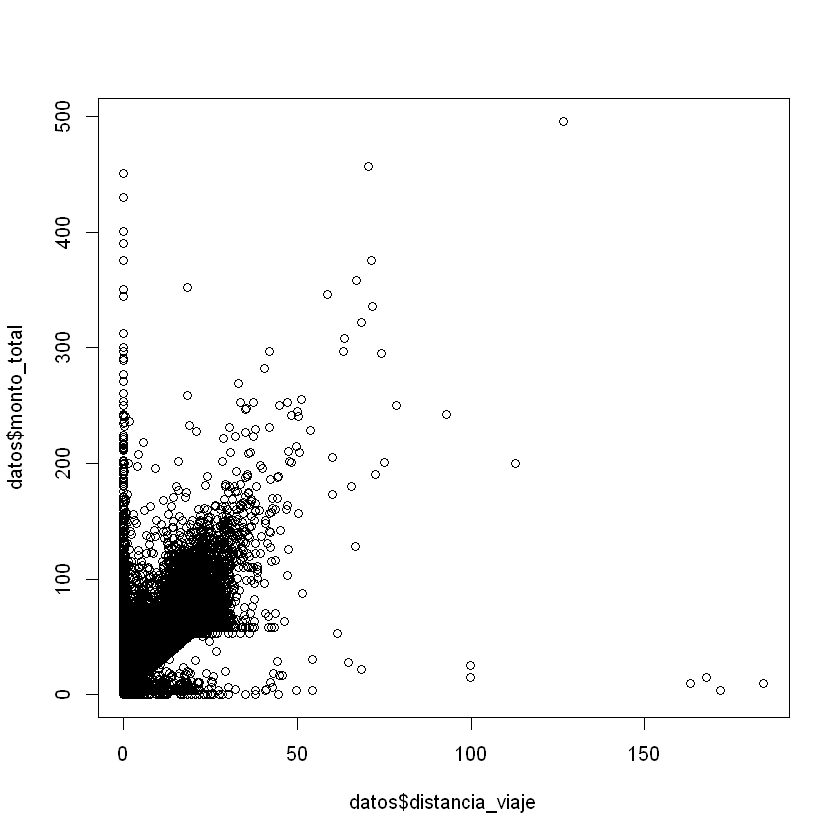

In [47]:
plot(datos$distancia_viaje, datos$monto_total)

In [54]:
summary(datos)

  id_proveedor  numero_pasajeros distancia_viaje   longitud_recogida
 Min.   :1.00   Min.   :0.000    Min.   :  0.000   Min.   :-131.82  
 1st Qu.:1.00   1st Qu.:1.000    1st Qu.:  1.000   1st Qu.: -73.99  
 Median :2.00   Median :1.000    Median :  1.690   Median : -73.98  
 Mean   :1.53   Mean   :1.667    Mean   :  2.867   Mean   : -72.77  
 3rd Qu.:2.00   3rd Qu.:2.000    3rd Qu.:  3.090   3rd Qu.: -73.97  
 Max.   :2.00   Max.   :9.000    Max.   :184.400   Max.   :   0.00  
 latitud_recogida  monto_total     id_codigo_tarifa guardar_y_reenviar
 Min.   : 0.00    Min.   :  0.00   Min.   :1.000    Min.   :0.000000  
 1st Qu.:40.74    1st Qu.:  8.30   1st Qu.:1.000    1st Qu.:0.000000  
 Median :40.75    Median : 11.60   Median :1.000    Median :0.000000  
 Mean   :40.09    Mean   : 15.47   Mean   :1.036    Mean   :0.006634  
 3rd Qu.:40.77    3rd Qu.: 17.15   3rd Qu.:1.000    3rd Qu.:0.000000  
 Max.   :60.91    Max.   :495.80   Max.   :6.000    Max.   :1.000000  
 hora_recogida     d